Next, you should install `diffusers==0.2.4` as well `scipy`, `ftfy` and `transformers`.

In [1]:
# !pip install diffusers==0.2.4
# !pip install transformers scipy ftfy
# !pip install "ipywidgets>=7,<8"

As google colab has disabled external widgtes, we need to enable it explicitly. Run the following cell to be able to use `notebook_login`

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

Now you can login with your user token.

In [ ]:
from huggingface_hub import notebook_login

# notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.15.layer_norm2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.weight'

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
from PIL import Image

In [ ]:
from torch import autocast

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [ ]:
prompt = ["Anthropomorphic Frog wearing a jacket and hat, bill henson style, platonic solids, art by Paul Gauguin"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 30            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(788)   # Seed generator to create the inital latent noise

batch_size = 1

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents_master = torch.randn(
  (batch_size, unet.in_channels, 40*height // 8, 40*width // 8),
  generator=generator,
)
latents_master = latents_master.to(torch_device)

In [ ]:
import torchvision

In [ ]:
from IPython.display import display
import numpy as np

In [ ]:
# torchvision.transforms.functional.resized_crop(latents_master, 2 , 2.1 , s , s , (64,64)  )

0it [00:00, ?it/s]

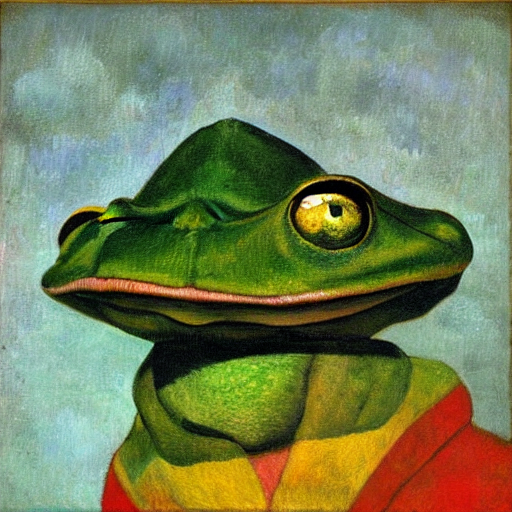

0it [00:00, ?it/s]

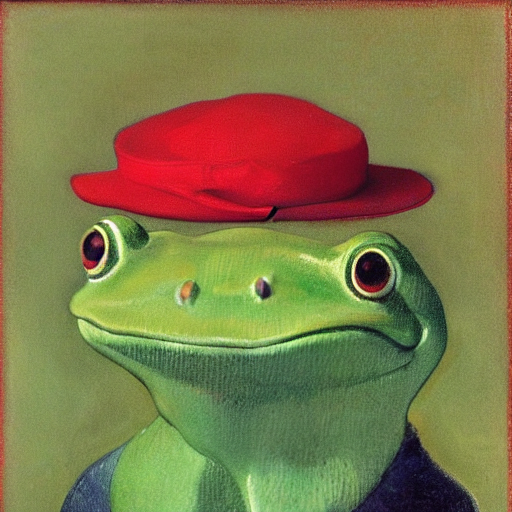

0it [00:00, ?it/s]

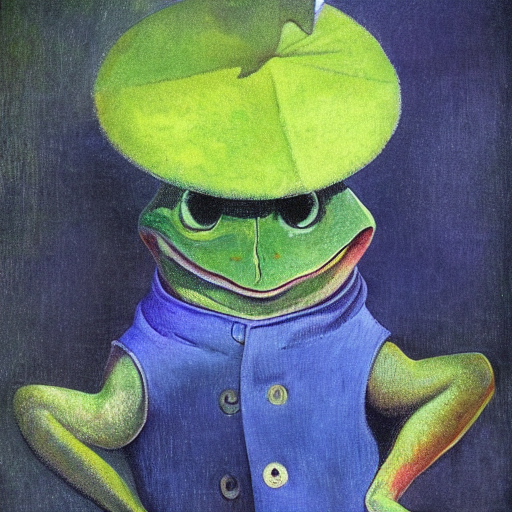

0it [00:00, ?it/s]

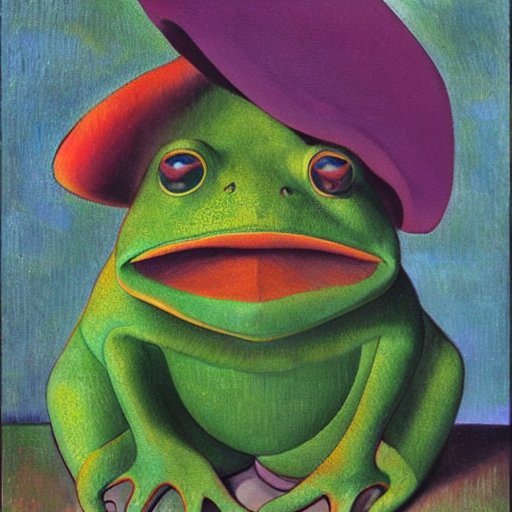

0it [00:00, ?it/s]

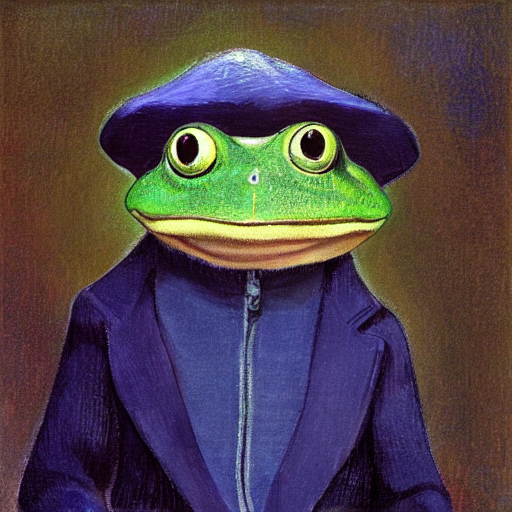

0it [00:00, ?it/s]

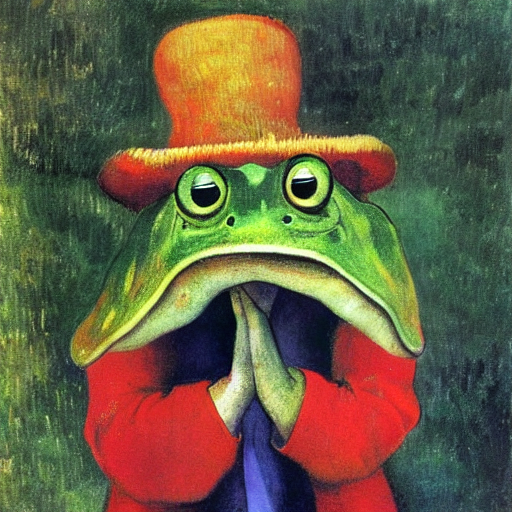

0it [00:00, ?it/s]

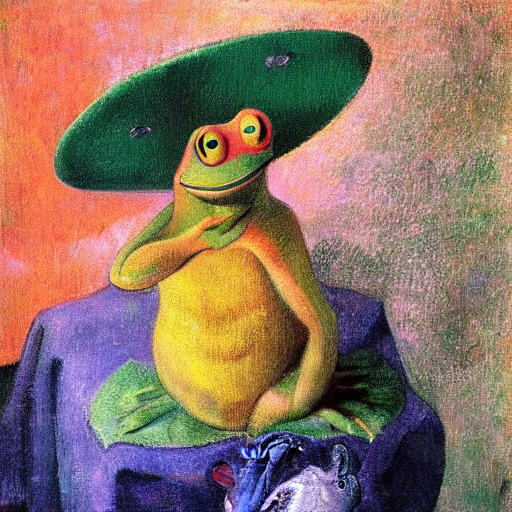

0it [00:00, ?it/s]

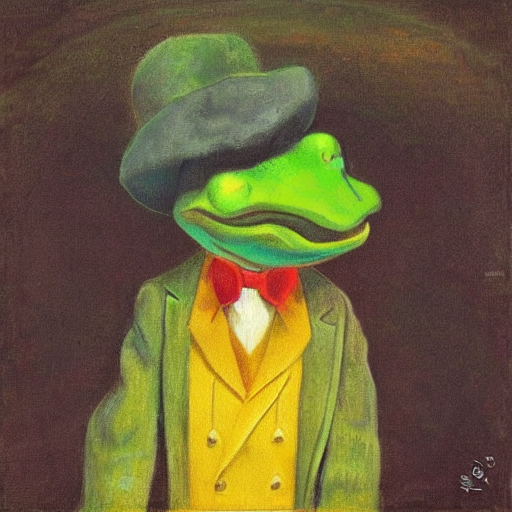

0it [00:00, ?it/s]

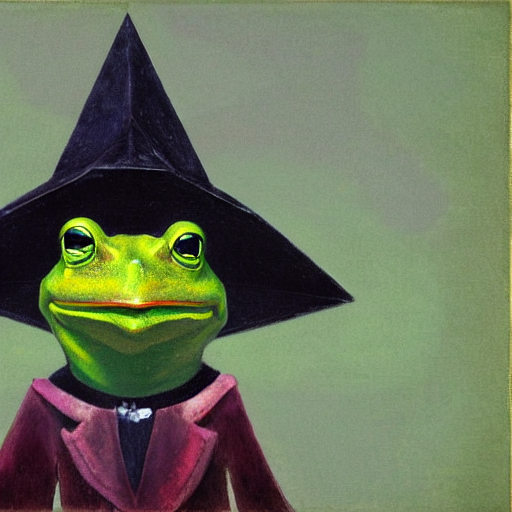

0it [00:00, ?it/s]

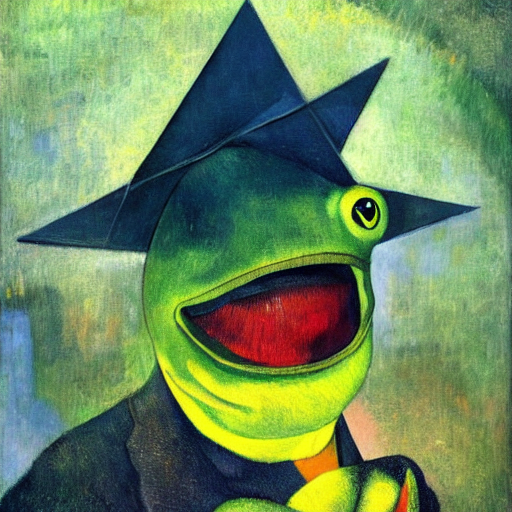

In [ ]:
x = 20
y = 20
s = 64 

for xx in range(10 ):
  x = xx*40
  y = xx*40

  latents = torchvision.transforms.functional.resized_crop(latents_master, x , y , s , s , (64,64) , interpolation=torchvision.transforms.InterpolationMode.NEAREST)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]
  from tqdm.auto import tqdm
  from torch import autocast

  with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
  # scale and decode the image latents with vae
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  display(pil_images[0])
